In [1]:
!pip install yahoo_fin
!pip install yahoo_fin --upgrade
!pip install dash
!pip install dash_table
!pip install colorlover
!pip install jupyter_dash

Requirement already up-to-date: yahoo_fin in /opt/anaconda3/lib/python3.7/site-packages (0.8.9.1)


In [4]:
import pandas as pd
import yahoo_fin as yfin 
import yahoo_fin.stock_info as st
import numpy as np
import matplotlib.pyplot as plt


# for Conditional Formatting
import dash
import dash_table
import dash_html_components as html
import colorlover
from jupyter_dash import JupyterDash

# Finance data  
def fin_data_points(tickets):    
    '''
    Computes finance data for the given list of assets (tickets)
    '''
    
    #tickets = ["MSFT","GM"]#,"BMW.DE","AAPL","NFLX","IBM"]

    def company_finance_fn(tbl_name,column_name):
        totalAssets_tbl = tbl_name.loc[column_name]
        totalAssets_maxdt = totalAssets_tbl.index.max()
        return totalAssets_tbl["endDate" == totalAssets_maxdt]    

    #create tbl:
    Company_Data = pd.DataFrame(columns = ['P/B','P/E','D/E','ROE','ROA',
                                       'NetProfit','GrossProfit','EBIT',
                                       'ProfitMargin', 'ForwardDividendYeild',
                                       'Name','Industry','Sector','Country', 'Currency'], index = tickets) 

    try:
        for i in range(len(tickets)):
            company = tickets[i]
        
            #get data from Yahoo Finance:
            info = st.get_company_info(company)
            forecast = st.get_analysts_info(company)
            balance_tbl = st.get_balance_sheet(company)
            income_tbl = st.get_income_statement(company)
            stats_tbl = st.get_stats(company)
            fins = st.get_financials(company, yearly = True, quarterly = False)
            fin_tbl = fins['yearly_income_statement']
            qd = st.get_quote_data(company)
        
            Company_Capitalization = qd['marketCap']
            Company_Assets = company_finance_fn(balance_tbl,"totalAssets")
            Company_Liabilities = company_finance_fn(balance_tbl,"totalLiab")
            Company_Equity =  Company_Assets - Company_Liabilities
            Company_NetProfit = company_finance_fn(income_tbl,"totalRevenue") #=totalRevenue 	
        
            #prepare fin data:
            PB = Company_Capitalization/abs(Company_Equity)
            PE = Company_Capitalization/Company_NetProfit
            #ForwardPE = qd['forwardPE']
            DE = Company_Liabilities/Company_Equity
            ROE = stats_tbl.iloc[34,1] #Return on Equity (ttm) 	
            ROA = stats_tbl.iloc[33,1]  #Return on Assets (ttm) 	
            NetProfit = company_finance_fn(income_tbl,"totalRevenue")
            GrossProfit = company_finance_fn(income_tbl,"grossProfit")
            Ebit = company_finance_fn(income_tbl,"ebit")
            ProfitMargin =  stats_tbl.iloc[31,1] #Profit Margin
            #DebtToEquity = stats_tbl.iloc[46,1] #Total Debt/Equity (mrq) 
            ForwardDividendYeild = stats_tbl.iloc[22,1] #Forward Annual Dividend Yield 4
        
            Name = qd['longName']
            Industry = info.loc['industry'].Value
            Sector = info.loc['sector'].Value   
            Country = info.loc['country'].Value  
            Currency = qd['currency']
        
            #Company_forecast_tbl = forecast['Growth Estimates']
        
            #fill tbl:
            Company_Data['P/B'].loc[company] = round(PB,4)
            Company_Data['P/E'].loc[company] = round(PE,4)
            #Company_Data['ForwardPE'].loc[company] = round(ForwardPE,4)
            Company_Data['D/E'].loc[company] = round(DE,2)
            Company_Data['ROE'].loc[company] = ROE
            Company_Data['ROA'].loc[company] = ROA
            Company_Data['NetProfit'].loc[company] = NetProfit
            Company_Data['GrossProfit'].loc[company] = GrossProfit
            Company_Data['EBIT'].loc[company] = Ebit
            Company_Data['ProfitMargin'].loc[company] = ProfitMargin
            #Company_Data['DebtToEquity'].loc[company] = DebtToEquity
            Company_Data['ForwardDividendYeild'].loc[company] = ForwardDividendYeild
        
            Company_Data['Name'].loc[company] = Name
            Company_Data['Industry'].loc[company] = Industry
            Company_Data['Sector'].loc[company] = Sector
            Company_Data['Country'].loc[company] = Country
            Company_Data['Currency'].loc[company] = Currency
    except:
        raise
    
    return Company_Data


def highlight_thebest_fin(data, color='green'):
    '''
    highlight the minimum in columns in "P/B","P/E","D/E"
    highlight the maximum in other columns
    '''
    
    min_v = ["P/B","P/E","D/E"]
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        if data.name not in min_v:
            is_max = data == data.max()
            return [attr if v else '' for v in is_max]
        else:
            is_min = data == data.min()
            return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index = data.index, columns = data.columns)



In [5]:
lt = ["MSFT","GM","BMW.DE","AAPL","NFLX","IBM"]
Company_Data = fin_data_points(lt)
Fin_Data = Company_Data.loc[:,'P/B':'ForwardDividendYeild']

In [6]:
#display finance data and highlight the best on each finance parameter
Fin_Data.style.apply(highlight_thebest_fin)

,P/B,P/E,D/E,ROE,ROA,NetProfit,GrossProfit,EBIT,ProfitMargin,ForwardDividendYeild
MSFT,15.650800,13.220600,1.350000,47.08%,13.76%,168088000000,115856000000,69916000000,36.45%,0.75%
GM,1.446300,0.586600,3.730000,24.88%,3.92%,122485000000,14502000000,8559000000,9.13%,0.00%
BMW.DE,0.836100,0.519600,2.520000,17.37%,3.43%,98990000000,12211000000,4837000000,9.93%,2.42%
AAPL,37.688100,8.970400,3.960000,127.13%,19.30%,274515000000,104956000000,66288000000,25.00%,0.54%
NFLX,23.948100,10.601300,2.550000,37.86%,9.72%,24996056000,9719737000,4585289000,15.92%,nan
IBM,5.925600,1.668200,6.530000,24.53%,3.84%,73621000000,35575000000,8584000000,7.17%,4.74%


In [7]:
#display general info
INFO_Data = Company_Data.loc[:,'Name':'Currency']
print(INFO_Data)

                                               Name  \
MSFT                          Microsoft Corporation   
GM                           General Motors Company   
BMW.DE  Bayerische Motoren Werke Aktiengesellschaft   
AAPL                                     Apple Inc.   
NFLX                                  Netflix, Inc.   
IBM     International Business Machines Corporation   

                               Industry                  Sector  \
MSFT            Software—Infrastructure              Technology   
GM                   Auto Manufacturers       Consumer Cyclical   
BMW.DE               Auto Manufacturers       Consumer Cyclical   
AAPL               Consumer Electronics              Technology   
NFLX                      Entertainment  Communication Services   
IBM     Information Technology Services              Technology   

              Country Currency  
MSFT    United States      USD  
GM      United States      USD  
BMW.DE        Germany      EUR  
AAPL    Unit

In [97]:
# Prices daily/weekly/ monthly price data from yfninace for the list of assets (as_lt)  - period = n_years
def yfin_dprices(lt, n_years = 5, n_interval = "1d"):
    from dateutil.relativedelta import relativedelta
    import datetime
    dt = datetime.date.today()    
    dt_minus_nyears = (dt - relativedelta(years = n_years)).strftime('%Y-%m-%d')
    dt = dt.strftime('%Y-%m-%d')

    prices = pd.DataFrame(columns=lt)

    for l in lt:
        #prices[l] = yf.download(l,dt_minus_nyears,dt)['Adj Close'] 
        
        #prices from yahoo_fin:
        prices[l] = st.get_data(l, start_date = dt_minus_nyears, end_date = dt, interval = n_interval)['adjclose']
    return prices


def yfin_wkprices(lt, n_years = 5 ): 
    #return yfin_dprices(lt, n_years, "1wk")
    return yfin_dprices(lt, n_years).resample('W').apply(lambda x: x[-1])
    

def yfin_mprices(lt, n_years = 5 ):
    #return yfin_dprices(lt, n_years, "1mo")
    return yfin_dprices(lt, n_years).resample('BM').apply(lambda x: x[-1])

# Returns daily/weekly/ monthly price data from yfninace for the list of assets (as_lt)

def yfin_dreturns(lt, n_years = 5):
    prices_daily = yfin_dprices(lt, n_years)
    returns_daily= prices_daily.pct_change()
    returns_daily = returns_daily.dropna() #delete Na   
    return returns_daily

def yfin_wkreturns(lt, n_years = 5 ):
    prices_weekly = yfin_wkprices(lt,n_years)
    returns_weekly = prices_weekly.pct_change()
    
    returns_weekly = returns_weekly.dropna() #delete Na
    #returns_daily = returns_daily.fillna(0, inplace=True)
    return returns_weekly 

def yfin_wkreturns_TB(lt, n_years = 5 ):
    prices_weekly = yfin_dprices(lt, n_years, "1wk")
    returns_weekly = prices_weekly.pct_change()
    
    returns_weekly = returns_weekly.dropna() #delete Na
    return returns_weekly 

def yfin_mreturns(lt, n_years = 5):
    prices_monthly = yfin_mprices(lt, n_years)
    returns_monthly = prices_monthly.pct_change()
    returns_monthly = returns_monthly.dropna() #delete Na
    
    returns_monthly.index = pd.to_datetime(returns_monthly.index, format="%Y%m").to_period('M')   
    return returns_monthly
    
    
# Risk Functions - annualizing returns, volatility (std dev), sharpe ratio coef, max drawdown
def annualize_rets(r, periods_per_year = 12):
    compounded_growth = (1 + r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods) - 1 #return (x+1)**Freq-1

def annualize_vol(r, periods_per_year = 12):
    return r.std()*(periods_per_year**0.5) #x*np.sqrt(Freq)

def RiskFree_wk(n_years):
    """
    take 13 Week Treasury Bill  as a risk-free rate - to calculate Sharpe ratio
    ^IRX from yfinance
    """
    TBill_wk = yfin_wkreturns_TB(lt = ["^IRX"],n_years = n_years)

    RiskFree_df = pd.DataFrame(columns = ['RET'], index = TBill_wk.index) 
    RiskFree_df['RET'] = (TBill_wk['^IRX'].values/100 + 1) ** (1 / 52) - 1 #weekly frequency = 52 per year


    RiskFree_df_weekly = (RiskFree_df['RET'] + 1).resample('W').prod() - 1 # to the same weekly frequency = 52 
    TBill_wk = pd.DataFrame(columns = ['T-Bill'], index = RiskFree_df_weekly.index)  #create a new dataframe 
    TBill_wk['T-Bill'] = RiskFree_df_weekly

    #ind = (TBill.index >= RiskFree_df_weekly.index[[0]][0])*(TBill.index <= RiskFree_df_weekly.index[[-1]][0])
    #TBill = TBill[ind] #keep the same start and end date as the stock returns data    
    return TBill_wk

def ann_sharpe_ratio(r, riskfree_rate, periods_per_year = 52): 
    n = len(r)
    ret_expected = np.sum(r - riskfree_rate)/n
    ret_avg = np.sum(r)/n
    std_dev = np.sqrt( np.sum( (r - ret_avg)**2 ) / n )
    ann_ret_expected = (ret_expected + 1)**periods_per_year - 1
    ann_std_dev = std_dev * np.sqrt(periods_per_year)
    return ann_ret_expected/ann_std_dev


def max_drawd(r):
    wealth = (r + 1).cumprod()
    cummax = wealth.cummax() 
    drawdown = wealth/cummax - 1 
    return drawdown.min()

In [98]:
period = 10

pricies_daily = yfin_dprices(lt, period)
returns_daily = yfin_dreturns(lt,period)

df = pricies_daily

# Display a brief summary of the dataset 
price_stat = pricies_daily.describe().T
display(price_stat)

,count,mean,std,min,25%,50%,75%,max
MSFT,2517.0,84.890246,69.706339,19.704594,33.253899,53.283924,111.516945,304.649994
GM,2517.0,30.457656,9.254604,14.530403,25.381048,28.995857,34.831600,63.919998
BMW.DE,2468.0,61.657028,11.939345,29.989342,54.992886,62.712780,69.375650,95.889999
AAPL,2517.0,42.894738,34.682456,11.148828,19.431713,28.597815,49.435886,156.690002
NFLX,2517.0,192.855218,170.505212,7.685714,50.330002,117.660004,337.489990,606.710022
IBM,2517.0,127.896799,12.031746,87.785240,120.301132,127.268356,137.820297,155.979538


In [99]:
# Recheck data
print(df.isnull().values.any())

True


In [100]:
df.count()

MSFT      2517
GM        2517
BMW.DE    2468
AAPL      2517
NFLX      2517
IBM       2517
dtype: int64

In [101]:
#display % of None data
df.isnull().sum()/df.count()*100

MSFT      0.000000
GM        0.000000
BMW.DE    1.985413
AAPL      0.000000
NFLX      0.000000
IBM       0.000000
dtype: float64

In [102]:
df.tail()

,MSFT,GM,BMW.DE,AAPL,NFLX,IBM
2021-09-03,301.140015,48.820000,79.400002,154.300003,590.530029,139.580002
2021-09-07,300.179993,48.720001,80.470001,156.690002,606.710022,138.059998
2021-09-08,300.209991,48.970001,78.610001,155.110001,606.049988,138.669998
2021-09-09,297.250000,48.419998,78.639999,154.070007,597.539978,137.740005
2021-09-10,295.709991,49.490002,79.150002,148.970001,598.719971,137.020004


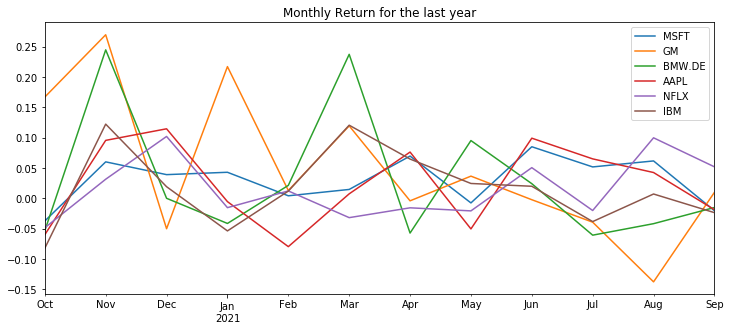

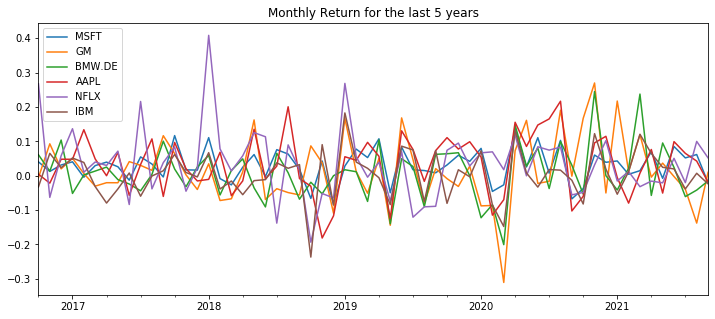

In [103]:
# Monthly return for the last year and for the last 5 years
returns_monthly= yfin_mreturns(lt,period)
returns_monthly.tail(12).plot(figsize = (12,5), title = 'Monthly Return for the last year')
returns_monthly.tail(12 *5).plot(figsize = (12,5), title = 'Monthly Return for the last 5 years')

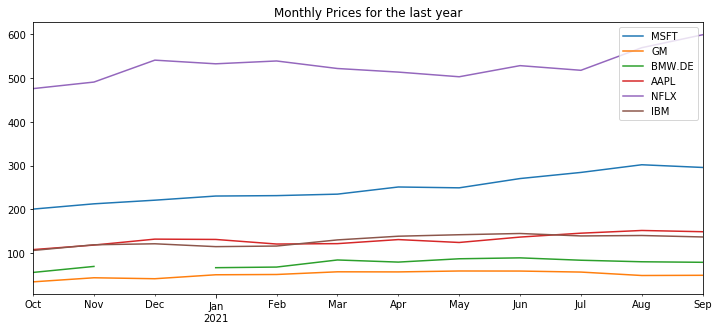

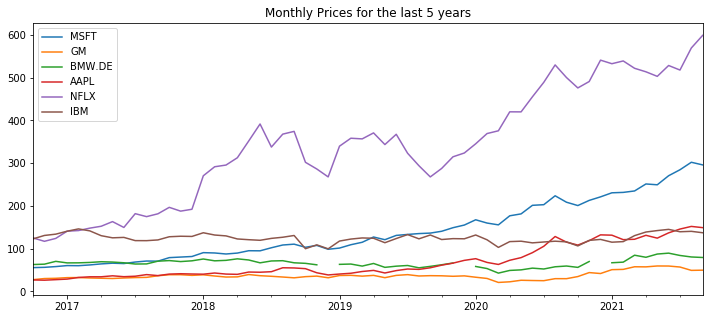

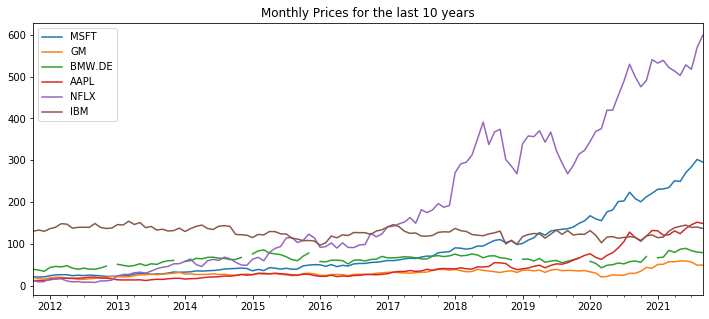

In [104]:
# Monthly prices for the last year, 5 and 10 years
pricies_monthly = yfin_mprices(lt,10)
pricies_monthly.tail(12).plot(figsize = (12,5), title = 'Monthly Prices for the last year')
pricies_monthly.tail(12 * 5).plot(figsize = (12,5), title = 'Monthly Prices for the last 5 years')
pricies_monthly.tail(12 * 10).plot(figsize = (12,5), title = 'Monthly Prices for the last 10 years')

In [105]:


#Summary Statistic

returns_weekly = yfin_wkreturns(lt,period)
TBill_wk = RiskFree_wk(period)

data = returns_weekly
SumStat = pd.DataFrame(index = data.columns)

SumStat['Annualize Returns(,%)'] = np.round( annualize_rets(data,52)*100, 2)
SumStat['Annualize Volatility(,%)'] = np.round( annualize_vol(data,52)*100, 2)
SumStat['Annual Sharpe Ratio'] = np.round(data.apply(ann_sharpe_ratio, riskfree_rate = TBill_wk['T-Bill'], periods_per_year = 52), 2)
SumStat['Max Drawdown(%)'] = np.round(data.apply(max_drawd)*100, 2)

max_rt = SumStat['Annualize Returns(,%)'].max()
pr_rt = max_rt * 0.5
SumStat['Rating Returns'] = SumStat['Annualize Returns(,%)'].apply(lambda x:
  '⭐⭐⭐' if x == max_rt else (   
   '⭐⭐' if x > pr_rt else (
  '⭐' if x > 0 else ''  #the first place
)))

SumStat['SR rating'] = SumStat['Annual Sharpe Ratio'].apply(lambda x: '🔥' if x == SumStat['Annual Sharpe Ratio'].max() else '')



In [106]:
# Display summary statistic
SumStat.sort_values('Annual Sharpe Ratio')

,"Annualize Returns(,%)","Annualize Volatility(,%)",Annual Sharpe Ratio,Max Drawdown(%),Rating Returns,SR rating
IBM,1.17,22.40,0.16,-43.12,⭐,
BMW.DE,7.58,28.65,0.42,-57.62,⭐,
GM,10.95,34.64,0.51,-56.44,⭐,
NFLX,38.95,53.15,1.10,-58.33,⭐⭐⭐,
AAPL,28.29,27.73,1.19,-43.64,⭐⭐,
MSFT,29.71,22.37,1.47,-25.69,⭐⭐,🔥


In [107]:
# Todays prices from the max price for the last 10 years ( in %)
df = pricies_daily
df.tail(1)/price_stat['max']*100

,MSFT,GM,BMW.DE,AAPL,NFLX,IBM
2021-09-10,97.065484,77.424911,82.542499,95.073074,98.683053,87.844858


In [108]:
# Todays prices
df.tail(1)

,MSFT,GM,BMW.DE,AAPL,NFLX,IBM
2021-09-10,295.709991,49.490002,79.150002,148.970001,598.719971,137.020004
